In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd
from astral.sun import sun
from astral import LocationInfo
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from skforecast.plot import plot_residuals
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size':8})

# Modelling and Forecasting
# ==============================================================================
import skforecast
import lightgbm
import sklearn
from lightgbm import LGBMRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import select_features
import shap
shap.initjs()

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

In [2]:
# Data download
# ==============================================================================
df = pd.read_csv(filepath_or_buffer='data/vic_elec.csv', index_col=0, parse_dates=True)
df.index = pd.to_datetime(df.index, utc=True, format='%Y-%m-%d %H:%M:%S')
df.head()

Demand  Temperature     Date  Holiday
Time                                                                 
2011-12-31 13:00:00+00:00  4382.825174        21.40  15340.0     True
2011-12-31 13:30:00+00:00  4263.365526        21.05  15340.0     True
2011-12-31 14:00:00+00:00  4048.966046        20.70  15340.0     True
2011-12-31 14:30:00+00:00  3877.563330        20.55  15340.0     True
2011-12-31 15:00:00+00:00  4036.229746        20.40  15340.0     True

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52608 entries, 2011-12-31 13:00:00+00:00 to 2014-12-31 12:30:00+00:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Demand       52608 non-null  float64
 1   Temperature  52608 non-null  float64
 2   Date         52608 non-null  float64
 3   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(3)
memory usage: 1.7 MB


In [4]:
df = df.asfreq('30min')
df.index

DatetimeIndex(['2011-12-31 13:00:00+00:00', '2011-12-31 13:30:00+00:00',
               '2011-12-31 14:00:00+00:00', '2011-12-31 14:30:00+00:00',
               '2011-12-31 15:00:00+00:00', '2011-12-31 15:30:00+00:00',
               '2011-12-31 16:00:00+00:00', '2011-12-31 16:30:00+00:00',
               '2011-12-31 17:00:00+00:00', '2011-12-31 17:30:00+00:00',
               ...
               '2014-12-31 08:00:00+00:00', '2014-12-31 08:30:00+00:00',
               '2014-12-31 09:00:00+00:00', '2014-12-31 09:30:00+00:00',
               '2014-12-31 10:00:00+00:00', '2014-12-31 10:30:00+00:00',
               '2014-12-31 11:00:00+00:00', '2014-12-31 11:30:00+00:00',
               '2014-12-31 12:00:00+00:00', '2014-12-31 12:30:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Time', length=52608, freq='30min')

In [5]:
df.head(2)

Demand  Temperature     Date  Holiday
Time                                                                 
2011-12-31 13:00:00+00:00  4382.825174        21.40  15340.0     True
2011-12-31 13:30:00+00:00  4263.365526        21.05  15340.0     True

In [6]:
# Verify that a temporary index is complete
# ==============================================================================
(df.index == pd.date_range(start=df.index.min(),
                             end=df.index.max(),
                             freq=df.index.freq)).all()

print(f"Number of rows with missing values: {df.isnull().any(axis=1).mean()}")

Number of rows with missing values: 0.0


In [7]:
df.drop(columns=['Date'], inplace=True)
df.resample(rule='h', closed='left', label='right').mean()
df.head()

Demand  Temperature  Holiday
Time                                                        
2011-12-31 13:00:00+00:00  4382.825174        21.40     True
2011-12-31 13:30:00+00:00  4263.365526        21.05     True
2011-12-31 14:00:00+00:00  4048.966046        20.70     True
2011-12-31 14:30:00+00:00  3877.563330        20.55     True
2011-12-31 15:00:00+00:00  4036.229746        20.40     True

In [8]:
# Split data into train-val-test
# ==============================================================================
from utils import split_data

end_train = '2013-12-31 23:59:00'
end_validation = '2014-11-30 23:59:00'
data, data_train, data_val, data_test = split_data(df, end_train, end_validation)

Train dates      : 2012-01-01 00:00:00+00:00 --- 2013-12-31 23:30:00+00:00  (n=35088)
Validation dates : 2014-01-01 00:00:00+00:00 --- 2014-11-30 23:30:00+00:00  (n=16032)
Test dates       : 2014-12-01 00:00:00+00:00 --- 2014-12-30 23:00:00+00:00  (n=1439)


In [9]:
# Interactive plot of time series
# ==============================================================================
from utils import plot_interactive_time_series

plot_interactive_time_series(data_train, data_val, data_test)

/Users/thomasvaudescal/Documents/Documents/3_CodingProjects/forecasting_energy_demand/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning:

backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



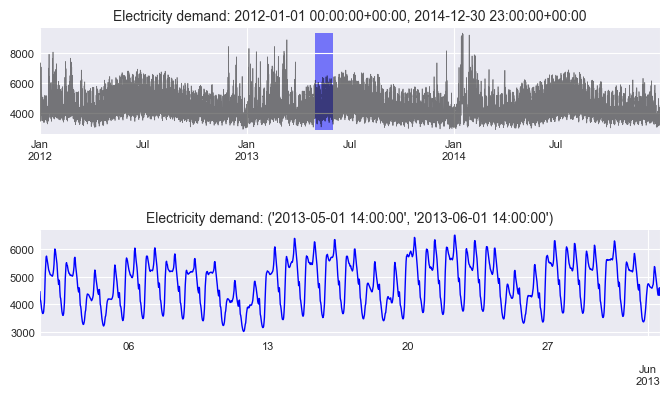

In [10]:
from utils import plot_zoomed_time_series

zoom_range = ('2013-05-01 14:00:00', '2013-06-01 14:00:00')
plot_zoomed_time_series(data, zoom_range)